# Final Project: Car vs Non-car
### Team 07

- A01281209 - Gabriel Bermúdez 
- A01570288 - Angel Guevara 
- A01656259 - Einar López 
- A01702218 - Valeria Betancourt

## 1 - Packages

Let's first import all the packages we will need. 
- [numpy](www.numpy.org) is the fundamental package for scientific computing with Python.
- [matplotlib](http://matplotlib.org) is a library to plot graphs in Python.
- [PIL](http://www.pythonware.com/products/pil/) and [scipy](https://www.scipy.org/) are used to test our model with our pictures.
- dnn_app_utils provides the functions implemented in the "Building your Deep Neural Network: Step by Step" assignment to this notebook.

In [16]:
import time
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage
from dnn_app_utils_v3 import *
import os

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 2 - Dataset

We will use a "Car vs Non-Car" dataset.

In [17]:
classes  = [b'non-car', b'car']
pathCar = './datasets/car/'
pathNonCar = './datasets/flower/'

# Get filenames of the images
arrCar = os.listdir(pathCar)
arrNonCar = os.listdir(pathNonCar)

# Label the data
arrCar = [[fname, 1] for fname in arrCar]
arrNonCar = [[fname, 0] for fname in arrNonCar]

# Put them together
arrData = arrCar + arrNonCar

# Sort by filaname to make sure that the filenames have a fixed order before shuffling
np.random.seed(1)
arrData.sort(key=lambda data: data[0])
np.random.shuffle(arrData)

# Add path
arrData = [[pathCar + fname, label] if label == 1 else [pathNonCar + fname, label] for fname, label in arrData]

# Open images and convert them to numpy arrays, each cell is compose by an RGB image [0] and label [1]
data = np.array([[np.array(Image.open(fname).convert('RGB')), label] for fname, label in arrData])

In [18]:
# Train %70, dev %15, test %15
train_size = int(len(arrData) * .10)
dev_size = int(len(arrData) * .15)
test_size = int(len(arrData) * .15)

# Get training set
train_x_orig = np.array([img[0] for img in data[:train_size]])
train_y = np.array([img for img in data[:train_size, 1]]).reshape(1, -1)
# Get dev set
dev_x_orig = np.array([img[0] for img in data[train_size:train_size + dev_size]])
dev_y = np.array([img for img in data[train_size:train_size + dev_size, 1]]).reshape(1, -1)
# Get test set
test_x_orig = np.array([img[0] for img in data[train_size + dev_size:]])
test_y = np.array([img for img in data[train_size + dev_size:, 1]]).reshape(1, -1)

print(train_x_orig.shape)
print(train_y.shape)
print(dev_x_orig.shape)
print(dev_y.shape)
print(test_x_orig.shape)
print(test_y.shape)

(400, 128, 128, 3)
(1, 400)
(600, 128, 128, 3)
(1, 600)
(3000, 128, 128, 3)
(1, 3000)


The following code will show you an image in the dataset. Feel free to change the index and re-run the cell multiple times to see other images. 

y = 0. It's a non-car picture.


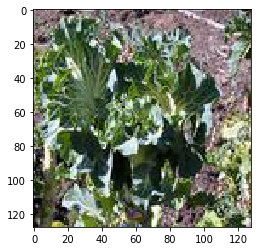

In [19]:
# Example of a picture
index = 15
plt.imshow(train_x_orig[index])
print ("y = " + str(train_y[0,index]) + ". It's a " + classes[train_y[0,index]].decode("utf-8") +  " picture.")

We can now explore our dataset.

In [20]:
m_train = train_x_orig.shape[0]
num_px = train_x_orig.shape[1]
m_dev = dev_x_orig.shape[0]
m_test = test_x_orig.shape[0]

print ("Number of training examples: " + str(m_train))
print ("Number of dev examples: " + str(m_dev))
print ("Number of testing examples: " + str(m_test))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_x_orig shape: " + str(train_x_orig.shape))
print ("train_y shape: " + str(train_y.shape))
print ("dev_x_orig shape: " + str(test_x_orig.shape))
print ("dev_y shape: " + str(test_y.shape))
print ("test_x_orig shape: " + str(test_x_orig.shape))
print ("test_y shape: " + str(test_y.shape))

Number of training examples: 400
Number of dev examples: 600
Number of testing examples: 3000
Each image is of size: (128, 128, 3)
train_x_orig shape: (400, 128, 128, 3)
train_y shape: (1, 400)
dev_x_orig shape: (3000, 128, 128, 3)
dev_y shape: (1, 3000)
test_x_orig shape: (3000, 128, 128, 3)
test_y shape: (1, 3000)


We need to reshape and standardize the images before feeding them to the network. The code is given in the cell below.

<img src="images/imvectorkiank.png" style="width:450px;height:300px;">

<caption><center> <u>Figure 1</u>: Image to vector conversion. <br> </center></caption>

In [21]:
# Reshape the training, dev and test examples 
train_x_flatten = train_x_orig.reshape(train_x_orig.shape[0], -1).T   # The "-1" makes reshape flatten the remaining dimensions
dev_x_flatten = dev_x_orig.reshape(dev_x_orig.shape[0], -1).T
test_x_flatten = test_x_orig.reshape(test_x_orig.shape[0], -1).T

# Standardize data to have feature values between 0 and 1.
train_x = train_x_flatten/255.
dev_x = dev_x_flatten/255.
test_x = test_x_flatten/255.

print ("train_x's shape: " + str(train_x.shape))
print ("dev_x's shape: " + str(dev_x.shape))
print ("test_x's shape: " + str(test_x.shape))

train_x's shape: (49152, 400)
dev_x's shape: (49152, 600)
test_x's shape: (49152, 3000)


$49,152$ equals $128 \times 128 \times 3$ which is the size of one reshaped image vector.

## 3 - Architecture of our model
### 3.1 - L-layer deep neural network

It is hard to represent an L-layer deep neural network with the above representation. However, here is a simplified network representation:

<img src="images/LlayerNN_kiank.png" style="width:650px;height:400px;">
<caption><center> <u>Figure 3</u>: L-layer neural network. <br> The model can be summarized as: ***[LINEAR -> RELU] $\times$ (L-1) -> LINEAR -> SIGMOID***</center></caption>

### 3.2 - General methodology

Deep Learning methodology to build the model:
    1. Initialize parameters / Define hyperparameters
    2. Loop for num_iterations:
        a. Forward propagation
        b. Compute cost function
        c. Backward propagation
        d. Update parameters (using parameters, and grads from backprop) 
    4. Use trained parameters to predict labels

## 4 - L-layer Neural Network

In [22]:
# GRADED FUNCTION: L_layer_model

def L_layer_model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 3000, print_cost=False):#lr was 0.009
    """
    Implements a L-layer neural network: [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID.
    
    Arguments:
    X -- data, numpy array of shape (number of examples, num_px * num_px * 3)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples)
    layers_dims -- list containing the input size and each layer size, of length (number of layers + 1).
    learning_rate -- learning rate of the gradient descent update rule
    num_iterations -- number of iterations of the optimization loop
    print_cost -- if True, it prints the cost every 100 steps
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """

    np.random.seed(1)
    costs = []                         # keep track of cost
    
    # Parameters initialization. (≈ 1 line of code)
    ### START CODE HERE ###
    parameters = initialize_parameters_deep(layers_dims)
    ### END CODE HERE ###
    
    # Loop (gradient descent)
    for i in range(0, num_iterations):

        # Forward propagation: [LINEAR -> RELU]*(L-1) -> LINEAR -> SIGMOID.
        ### START CODE HERE ### (≈ 1 line of code)
        AL, caches = L_model_forward(X, parameters)
        ### END CODE HERE ###
        
        # Compute cost.
        ### START CODE HERE ### (≈ 1 line of code)
        cost = compute_cost(AL, Y)
        ### END CODE HERE ###
    
        # Backward propagation.
        ### START CODE HERE ### (≈ 1 line of code)
        grads = L_model_backward(AL, Y, caches)
        ### END CODE HERE ###
 
        # Update parameters.
        ### START CODE HERE ### (≈ 1 line of code)
        parameters = update_parameters(parameters, grads, learning_rate)
        ### END CODE HERE ###
                
        # Print the cost every 100 training example
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
        if print_cost and i % 100 == 0:
            costs.append(cost)
            
    # plot the cost
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

## 4-layer neural network.
### Training

In [23]:
### CONSTANTS ###
layers_dims = [49152, 20, 7, 5, 1] #  4-layer model

Cost after iteration 0: 0.691361
Cost after iteration 100: 0.611601
Cost after iteration 200: 0.559532
Cost after iteration 300: 0.515919
Cost after iteration 400: 0.467421
Cost after iteration 500: 0.413170
Cost after iteration 600: 0.371156
Cost after iteration 700: 0.320274
Cost after iteration 800: 0.287255
Cost after iteration 900: 0.245732
Cost after iteration 1000: 0.218935
Cost after iteration 1100: 0.204568
Cost after iteration 1200: 0.185778
Cost after iteration 1300: 0.172785
Cost after iteration 1400: 0.162568
Cost after iteration 1500: 0.154289
Cost after iteration 1600: 0.150548
Cost after iteration 1700: 0.137171
Cost after iteration 1800: 0.127855
Cost after iteration 1900: 0.119293
Cost after iteration 2000: 0.113075
Cost after iteration 2100: 0.107121
Cost after iteration 2200: 0.102492
Cost after iteration 2300: 0.098669
Cost after iteration 2400: 0.095069


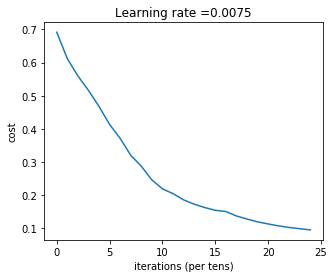

In [24]:
parameters = L_layer_model(train_x, train_y, layers_dims, num_iterations = 2500, print_cost = True)

### Testing

In [25]:
pred_train = predict(train_x, train_y, parameters)

Accuracy: 0.9924999999999998


In [26]:
pred_train = predict(dev_x, dev_y, parameters)

Accuracy: 0.6900000000000001


In [27]:
pred_test = predict(test_x, test_y, parameters)

Accuracy: 0.6903333333333335
